# Treat Data

## Join DFS
Start by joining dfs from all counties together

In [1]:
import pandas
counties = ["Alenquer", "Amadora", "Arruda dos Vinhos", "Azambuja", "Cadaval", "Cascais", "Lisboa", "Loures", "Lourinhã", "Mafra", "Odivelas", "Oeiras", "Sintra", "Sobral de Monte Agraço", "Torres Vedras", "Vila Franca de Xira"]
dfs = []
for county in counties:
    df = pandas.read_pickle("Data/" + county + ".pkl")
    dfs.append(df)
    
df = pandas.concat(dfs)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10375 entries, 0 to 44
Data columns (total 46 columns):
accuracyRating           7990 non-null float64
allowsChildren           10373 non-null object
allowsEvents             10373 non-null object
allowsInfants            10373 non-null object
allowsPets               10373 non-null object
allowsSmoking            10373 non-null object
amenities                10375 non-null object
bathrooms                10366 non-null float64
bedrooms                 10363 non-null float64
beds                     10369 non-null float64
checkin                  10375 non-null object
checkinRating            7986 non-null float64
checkout                 10375 non-null object
cleanlinessRating        7991 non-null float64
communicationRating      7988 non-null float64
country                  10373 non-null object
hostDate                 10373 non-null object
id                       10375 non-null object
isBusinessTravel         10373 non-null objec

## Check Room Uniqueness

when gathering the data, we searched Airbnb by county. The problem is that many of the rooms overlap when searching on Airbnb, which created an excessive amount of duplicated rooms

In [2]:
#delete duplicated rooms
print("total rooms before cleaning: " + str(len(df)))
f = df.sort_values("id", ascending=True)
df = df.drop_duplicates(subset="id", keep="first")
print("total rooms after cleaning: " + str(len(df)))

total rooms before cleaning: 10375
total rooms after cleaning: 1996


## Delete NAN or NULL value

In [3]:
#first check the variables with the most nulls
print(df.isnull().sum(axis=0))

accuracyRating           458
allowsChildren             1
allowsEvents               1
allowsInfants              1
allowsPets                 1
allowsSmoking              1
amenities                  0
bathrooms                  5
bedrooms                   3
beds                       3
checkin                    0
checkinRating            460
checkout                   0
cleanlinessRating        457
communicationRating      459
country                    1
hostDate                   1
id                         0
isBusinessTravel           1
isFullyRefundable          1
isHotel                    1
isInstantBookPossible      1
isSuperHost                1
isVerified                 1
languages                  0
lastUpdate                 7
latitude                   1
location                   1
locationRating           461
longitude                  1
minNights                  1
monthlyPriceFactor         1
name                       1
personCapacity             1
pictureCount  

after analyzing the dataframe, we found that more than 99% of the missing data was in the rating parameters, which we would not want to manipulate by any means, fearing that it could compromise the results

In [4]:
print("total rooms before cleaning: " + str(len(df)))
#df = df.dropna(subset=["rating", "bedrooms"])
df = df.dropna()
print("total rooms after cleaning: " + str(len(df)))

total rooms before cleaning: 1996
total rooms after cleaning: 1216


### 5. Deal with locations
Locations are difficult to deal with.
From the data gathered from Airbnb, we had the location string of the room, which is a manual input of the Airbnb host, and, therefore, extremely unreliable. Our goal was to transform this string to one of the Lisbon counties and, by doing this, get a reliable categorical parameter. In order to do so, we had to standardize the input string

In [5]:
#How many unique location strings?
print(len(df["location"].unique()))

151


In [6]:
import re
#How many different locations with word "oeiras"? And "cascais"?
print(df[df['location'].str.match('.*oeiras.*', flags=re.IGNORECASE)]["location"].unique())
print(df[df['location'].str.match('.*cascais.*', flags=re.IGNORECASE)]["location"].unique())

['Oeiras, Lisboa, Portugal' 'Oeiras, Lisbon, Portugal'
 'LISBOA, OEIRAS, Portugal']
['Cascais, Lisboa, Portugal' 'Cascais, Lisbon, Portugal'
 'Estoril, Cascais, Portugal' 'Cascais, Lisbon District, Portugal'
 'Cascais, Portugal' 'Cascais, Costa da Guia, Portugal'
 'Costa da Guia - Torre, Cascais, Portugal'
 'São João do Estoril, Cascais, Portugal']


As you can see, this is a problem. How can we uniquely identify "Oeiras, Lisbon" and "LISBOA, OEIRAS" to be the same?
We decided to use the power of google maps api to do this. If we search these two strings, it will give back Oeiras in both, for sure.

In [7]:
#get unique locations case insensitive and search google for only unique. This saves a lot of requests and time.
from Locations import Location
import json

uniqueLocs = df["location"].str.lower().unique()

#read from file
with open("data\\locsDic.json", 'r', encoding="utf-8") as f:
    locsDic = json.load(f)
        
for loc in uniqueLocs:
    if loc not in locsDic and loc is not None:
        print(loc)
        sr = Location(loc).county
        locsDic[loc] = sr #this still takes some time!
        if sr != None:
            locsDic[sr] = sr #this is just so that if we run twice, we will get the same results

# save so we dont have to request all next time
with open("data\\locsDic.json", 'w', encoding="utf-8") as f:
    json.dump(locsDic, f, ensure_ascii=False)
    
df["location"] = df["location"].apply(lambda x : locsDic[x.lower()]) #replace each location by its corresponding google value in locsDic

#clean none locations
print("total rooms before cleaning: " + str(len(df)))
#df = df.dropna(subset=["rating", "bedrooms"])
df = df.dropna()
print("total rooms after cleaning: " + str(len(df)))

total rooms before cleaning: 1216
total rooms after cleaning: 1139


Now we only have 1 Oeiras and 1 Cascais, as we wanted

In [8]:
print(df[df['location'].str.match('.*oeiras.*', flags=re.IGNORECASE)]["location"].unique())
print(df[df['location'].str.match('.*cascais.*', flags=re.IGNORECASE)]["location"].unique())

['oeiras']
['cascais']


We are left with only 16 locations, which are the counties

In [9]:
len(df["location"].unique())

16

Still regarding locations, we also added a new column to the dataframe called distToCenter, which was computed by finding the distance between the room coordinates (gotten from Airbnb) and the center of Lisbon, using the Haversine formula. This method is a static method of the class Location.

In [10]:
#now we need to apply distance function and create a new column
def distance(row):
    lat1 = row["latitude"]
    long1 = row["longitude"]
    lat2 = 38.710555
    long2 = -9.143411
    distance = Location.getDistance(lat1, long1, lat2, long2)
    return distance

#TODO -> Something bad is happening. When a room is duplicated, the county they belong to is difficult to assert.
#Instead of giving the distance to all county centers, we'll just do to the center of Lisbon.
df["distToCenter"] = df.apply(lambda row : distance(row), axis = 1)

#how it works for 5 rooms in lisbon:
df[["location", "latitude", "longitude", "distToCenter"]].loc[df["location"]=="lisboa"].head(5)

,location,latitude,longitude,distToCenter
1,lisboa,38.74498,-9.20654,6.681428
7,lisboa,38.72649,-9.11715,2.886246
8,lisboa,38.75438,-9.18236,5.929691
10,lisboa,38.70450,-9.16794,2.232353
12,lisboa,38.73787,-9.16691,3.657980


After computing the distToCenter, we found that some rooms had a very unrealistic value for its county. This means that either the county classification was not well performed, or the coordinates were wrong from the start. Either way, we decided to define a maximum distance to the center of Lisbon, by county, and remove all the rooms that did not respect that limit. For instance, there were 2 rooms in the county of Lisbon that were more than 40km away from the center. This is obviously impossible.

In [11]:
#outliers do distToCenter por municipio

#max possible distance
maxDist = {"alenquer":60, "amadora":20, "vila-franca-de-xira":50, "arruda-dos-vinhos":50, "azambuja":65, "cadaval":80,
           "cascais":40, "lisboa":15, "loures":25, "lourinha":80, "mafra":45, "odivelas":25, "oeiras":30, "sintra":35,
           "sobral-de-monte-agraco":50, "torres-vedras": 60}

print("initial" + " " + str(df.shape))

for county in maxDist:
    df = df.loc[~((df["location"] == county) & (df["distToCenter"] > maxDist[county]))]
    print(county + " " + str(df.shape) )



initial (1139, 47)
alenquer (1139, 47)
amadora (1137, 47)
vila-franca-de-xira (1137, 47)
arruda-dos-vinhos (1137, 47)
azambuja (1137, 47)
cadaval (1137, 47)
cascais (1136, 47)
lisboa (1134, 47)
loures (1134, 47)
lourinha (1134, 47)
mafra (1131, 47)
odivelas (1131, 47)
oeiras (1128, 47)
sintra (1127, 47)
sobral-de-monte-agraco (1127, 47)
torres-vedras (1127, 47)


### More data transformation
amenities, languages and dates

In [12]:
import datetime as dt

#dates to numeric values
#we decided to convert the two datetimes we had, last update of the room and date of creation of host account,
#to numerical values, by subtracting it from today’s date
df["lastUpdate"] =  pandas.to_datetime(df["lastUpdate"], format="%Y-%m-%d")
df["hostDate"] =  pandas.to_datetime(df["hostDate"], format="%Y-%m-%d")
df["monthsSinceCreation"] = -(df["hostDate"] - dt.datetime.now()).dt.days/30
df["daysSinceUpdate"] = -(df["lastUpdate"] - dt.datetime.now()).dt.days
del df["hostDate"]
del df["lastUpdate"]

#lists to count
#for the two lists we had, amenities and languages, we decided to simplify and simply count the number for each one, by room
df["totalAmenities"] = df["amenities"].apply(lambda row : len(row))
df["totalLanguages"]=df["languages"].apply(lambda row : len(row))
del df["amenities"]
del df["languages"]

#remove rooms with "no quality"
print("total rooms before cleaning: " + str(len(df)))
#with few reviews
df=df[df['reviewsCount']>=3]
#with no beds
df = df[df["beds"] > 0]
#with no people
df = df[df["personCapacity"] > 0]
#with no pictures
df = df[df["pictureCount"] > 0]
print("total rooms after cleaning: " + str(len(df)))

#delete other parameters not needed
del df["name"]
del df["checkin"]
del df["checkout"]
del df["country"]
del df["latitude"]
del df["longitude"]

# set index
df = df.set_index("id")

df.info()

total rooms before cleaning: 1127
total rooms after cleaning: 1123
<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 21888626 to 3671486
Data columns (total 40 columns):
accuracyRating           1123 non-null float64
allowsChildren           1123 non-null object
allowsEvents             1123 non-null object
allowsInfants            1123 non-null object
allowsPets               1123 non-null object
allowsSmoking            1123 non-null object
bathrooms                1123 non-null float64
bedrooms                 1123 non-null float64
beds                     1123 non-null float64
checkinRating            1123 non-null float64
cleanlinessRating        1123 non-null float64
communicationRating      1123 non-null float64
isBusinessTravel         1123 non-null object
isFullyRefundable        1123 non-null object
isHotel                  1123 non-null object
isInstantBookPossible    1123 non-null object
isSuperHost              1123 non-null object
isVerified               1123 no

### DATA TYPES
Assure all parameters have the right type

In [13]:
#set type of all columns
typeObject={
    "accuracyRating": float, 
    "allowsChildren": "uint8", 
    "allowsEvents": "uint8", 
    "allowsInfants": "uint8", 
    "allowsPets": "uint8", 
    "allowsSmoking": "uint8", 
    "bathrooms": float, 
    "bedrooms": float, 
    "beds": float, 
    "checkinRating": float, 
    "cleanlinessRating": float, 
    "communicationRating": float, 
    "isBusinessTravel": "uint8", 
    "isFullyRefundable": "uint8", 
    "isHotel": "uint8", 
    "isInstantBookPossible": "uint8", 
    "isSuperHost": "uint8", 
    "isVerified": "uint8", 
    "location" : "category",
    "locationRating": float, 
    "minNights": int, 
    "monthlyPriceFactor": float, 
    "personCapacity": int, 
    "pictureCount": int, 
    "ratePerNight": float, 
    "rating": "category", 
    "ratingC": float, 
    "responseRate": float, 
    "reviews" : object,
    "reviewsCount" : int,
    "roomType" : "category",
    "serviceFee": float, 
    "totalPrice": float, 
    "url": str,
    "distToCenter" : float,
    "monthsSinceCreation" : float,
    "daysSinceUpdate" : float,
    "totalLanguages" : int,
    "totalAmenities" : int
} 

#it's ordered, we need to specify order manually
rtCategory=pandas.api.types.CategoricalDtype( categories = ["within an hour", "within a few hours", "within a day", "a few days or more"], ordered = True)
df["responseTime"] = df["responseTime"].astype(rtCategory)

df = df.astype(typeObject)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 21888626 to 3671486
Data columns (total 40 columns):
accuracyRating           1123 non-null float64
allowsChildren           1123 non-null uint8
allowsEvents             1123 non-null uint8
allowsInfants            1123 non-null uint8
allowsPets               1123 non-null uint8
allowsSmoking            1123 non-null uint8
bathrooms                1123 non-null float64
bedrooms                 1123 non-null float64
beds                     1123 non-null float64
checkinRating            1123 non-null float64
cleanlinessRating        1123 non-null float64
communicationRating      1123 non-null float64
isBusinessTravel         1123 non-null uint8
isFullyRefundable        1123 non-null uint8
isHotel                  1123 non-null uint8
isInstantBookPossible    1123 non-null uint8
isSuperHost              1123 non-null uint8
isVerified               1123 non-null uint8
location                 1123 non-null category
locationRating  

In [14]:
df.to_pickle("data\\final2.pkl")
len(df)

1123

In [15]:
df['roomType'].value_counts().plot(kind='bar')

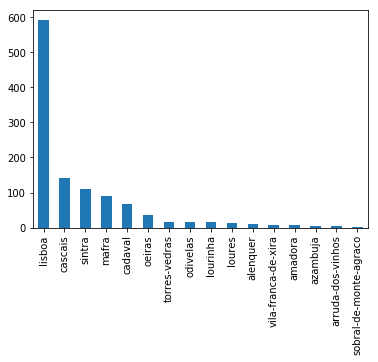

In [16]:
df['location'].value_counts().plot(kind='bar')

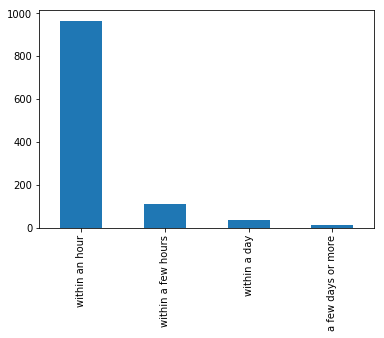

In [17]:
df['responseTime'].value_counts().plot(kind='bar')

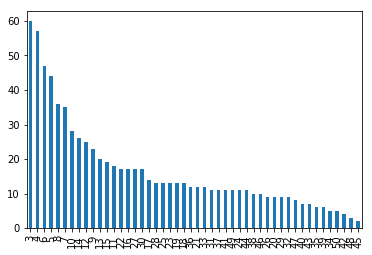

In [18]:
newdf=df[df['reviewsCount']<=50]
newdf["reviewsCount"].value_counts().plot(kind='bar')